# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import datetime
from datetime import datetime, timedelta

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from collections import Counter
import re
from sklearn.preprocessing import StandardScaler        

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 369

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df_train.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [8]:
df_test.head(3)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638


In [9]:
sample_submission.head(3)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

rest = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [12]:
rest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [13]:
rest.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Price Range',
       'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA', 'sample', 'Rating'],
      dtype='object')

Убираем  ненужный столбец и приводим названия остальных столбцов к PEP8

In [14]:
rest = rest.drop(['URL_TA'], axis=1)
rest.columns = ['restaurant_id', 'city', 'cuisine_style', 'ranking', 'price_range', 
                'number_of_reviews', 'reviews', 'id_ta', 'sample', 'Rating']

In [15]:
rest.sample(3)

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,id_ta,sample,Rating
4777,id_4777,Milan,['Italian'],386.0,$,274.0,"[['Food for foodies', 'top'], ['12/30/2016', '...",d2664493,0,0.0
8512,id_8512,Paris,['Chinese'],11903.0,NaN,7.0,"[['worth the money'], ['04/10/2016']]",d4431418,0,0.0
22333,id_692,Helsinki,"['Bar', 'Fusion', 'Scandinavian', 'European']",693.0,$$ - $$$,27.0,"[['Wintertime, Uunisaari', 'Nice'], ['12/29/20...",d850170,1,3.5


In [16]:
rest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
restaurant_id        50000 non-null object
city                 50000 non-null object
cuisine_style        38410 non-null object
ranking              50000 non-null float64
price_range          32639 non-null object
number_of_reviews    46800 non-null float64
reviews              49998 non-null object
id_ta                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(6)
memory usage: 3.8+ MB


Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [17]:
# Имеем 4 признака с пропусками
rest['number_of_reviews_NAN'] = pd.isna(rest['number_of_reviews']).astype('uint8')
rest['cuisine_style_NAN'] = pd.isna(rest['cuisine_style']).astype('uint8')
rest['price_range_NAN'] = pd.isna(rest['price_range']).astype('uint8')
rest['reviews_NAN'] = pd.isna(rest['reviews']).astype('uint8')

In [18]:
rest['number_of_reviews_NAN'].value_counts()

0    46800
1     3200
Name: number_of_reviews_NAN, dtype: int64

Пропуски заполним в следующем разделе 

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

Какие признаки можно считать категориальными?

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

dummy variables добавим позже

Рассмотрим каждый признак по-очереди, попробуем из каждого вытащить какие-либо числовые значения. Видим, что группировать лучше по городу, т.к. в 'price_range' много пустых, а другие столбцы не подходят для groupby()

Приведем 'restaurant_id' к числовому типу, так как в нем есть нумерация 

In [19]:
def f0(x):
    if 'id_' in str(x):
        return str(x).replace('id_', '')
    else: return x
    
    
rest.restaurant_id = rest.restaurant_id.apply(f0)
rest.restaurant_id = pd.to_numeric(rest.restaurant_id)
rest['restaurant_id'].sample(3)

5274     5274
46701    2060
1329     1329
Name: restaurant_id, dtype: int64

Новый признак 1: 'ranking', нормированный по максимальному в городе. Находим макс 'ranking' внутри каждого города и нормируем признак 'ranking', округляя до 4го знака

In [20]:
rest['new1_ranking'] = rest.groupby('city')['ranking'].apply(lambda x: round(x/x.max()*10, 4))
rest['new1_ranking'].head()

0    9.2686
1    0.9290
2    4.5866
3    1.0150
4    0.4162
Name: new1_ranking, dtype: float64

In [21]:
rest['new10_ranking'] = rest['city'].map(rest['city'].value_counts().to_dict())/rest['ranking']
rest['new10_ranking'].head(3)

0    0.471187
1    4.481132
2    0.919753
Name: new10_ranking, dtype: float64

Создадим новый признак на основе порядкового столбца  'price_range'. Если результат работы алгоритма улучшится,
то смысл в этом есть(проверим вместе с другими новыми признаками позже)
Заменим в  'price_range' значения на числа с использованием словаря

In [22]:
price_dict = {'$': 1, '$$ - $$$': 2, '$$$$': 3}
rest['new2_price_range'] = rest.price_range.replace(to_replace=price_dict)
rest['price_range'] = rest['price_range'].fillna('$$ - $$$')
# Заполняем пропущенные значения price_range внутри каждого города средним по городу
rest['new2_price_range'] = rest.groupby('city')['new2_price_range'].apply(lambda x: round(x.fillna(x.mean()), 4))
# Составляем датафрейм, а потом словарь для замены всех значений на средние по городу
city_price = rest.groupby('city')['new2_price_range'].apply(lambda x: round(x.mean(), 4)).reset_index()
city_dict = {city_price.city[i]: city_price.new2_price_range[i] for i in range(31)}

# Новый признак 2: средний 'price_range' по городу, отражает дороговизну ресторанов города
# Растянем шкалу значений, чтобы разброс был больше
rest['new2_price_range'] = rest.city.replace(to_replace=city_dict)
rest['new2_price_range'] = round(
    10*(rest['new2_price_range'] - rest['new2_price_range'].min()), 4)
rest['new2_price_range'].head()

0    2.393
1    2.150
2    0.575
3    1.564
4    2.111
Name: new2_price_range, dtype: float64

Новый признак 3: заменим пропущенные значения в 'number_of_reviews' на средние по городу,
а потом все значения поделим на наибольшее в городе

In [23]:
rest['number_of_reviews'] = rest.groupby('city')['number_of_reviews'].apply(lambda x: 
                                                                    round(x.fillna(x.mean()), 4))
rest['new3_number_of_reviews'] = rest.groupby('city')['number_of_reviews'].apply(lambda x: 
                                                                    round(x/x.max()*100, 4))
rest['new3_number_of_reviews'].sample(3)

35490    0.1242
7740     0.5155
41274    2.8272
Name: new3_number_of_reviews, dtype: float64

Из столбца 'cuisine_style' сделаем 2 новых признака: new4 - кол-во кухонь, представленных в ресторане и 
new5 - сумма количеств встреч кухонь ресторана в общем списке кухонь
dummy variables пока не используем
Сначала заменим  пропущенные значения в 'cuisine_style' на список из 3х самых популярных в данном городе
Создаем вспомогательный датафрейм rest2, удаляя пропущенные в 'cuisine_style' и преобразуя строки в списки 

In [24]:
rest2 = rest.dropna(subset=['cuisine_style'])
rest2 = rest2.reset_index().drop('index', axis=1)
rest2['cuisine_style'] = rest2['cuisine_style'].apply(lambda x: x[2:-2].split("', '"))

In [25]:
# Создаем список городов city_list
city_list = list(set(rest2['city']))
# В цикле по каждому городу отбираем 3 наиболее часто встречающиеся кухни
for ci in city_list:    
    cuisine = list(rest2['cuisine_style'][rest2['city'] == ci])    
    cuisine_list = [j for i in cuisine for j in i]
    cmc = Counter(cuisine_list).most_common()
    cousine_3cmc = [cmc[0][0], cmc[1][0], cmc[2][0]]  # вот они
# Теперь заполняем в исходном rest пропущенные значения 'cuisine_style' в строковом формате    
    rest['cuisine_style'].loc[rest['city'] == ci] = rest['cuisine_style'][rest['city'] 
                                                            == ci].fillna(str(cousine_3cmc))

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Вопрос к проверяющему: почему выдается предупреждение? Вроде loc на месте.

In [26]:
# Создадим серию из видов кухонь cuisine_col, состоящую из списков вместо строк
cuisine_col = rest['cuisine_style'].apply(lambda x: x[2:-2].split("', '"))
#pd.DataFrame(cuisine_col.tolist()).stack().value_counts()

# Новый признак 4: количество разных кухонь, представленных в ресторане(этот признак можно 
# было сделать гораздо проще)
rest['new4_cuisine_style'] = cuisine_col.apply(lambda x: round(len(x), 1))

In [27]:
# Создадим список всех типов кухонь в датафрейме, их 125    
cuisine_list1 = [j for i in list(cuisine_col) for j in i]
cuisine_list = list(set(cuisine_list1))
# Посчитаем, сколько раз каждая кухня встречается в данных
cuisine_pop_list = Counter(cuisine_list1).most_common()
# Создадим словарь, где ключи-названия кухонь, значения их количествa
cuisine_pop_dict = {cuisine_pop_list[i][0]: cuisine_pop_list[i][1] for i in range(125)}

In [28]:
# Ф-ция для суммирования значений словаря в списке
def f1(x):
    y = sum(list(map(lambda x: cuisine_pop_dict[x], x)))    
    return round(y/len(x)/10000, 4)

Новый признак 5: суммируем для каждого ресторана количества раз, сколько каждая кухня ресторана представлена в датафрейме и
делим на кол-во кухонь в данном ресторане. Отображает наличие в ресторане популярных кухонь
Находим в словаре числа, соответствующие кухням и суммируем их построчно в серии cuisine_col

In [29]:
rest['new5_cuisine_style'] = cuisine_col.apply(f1)
rest['new5_cuisine_style'].head(3)

0    0.3648
1    1.1428
2    2.4611
Name: new5_cuisine_style, dtype: float64

Создадим еще один новый признак 'сколько дней прошло с даты последнего отзыва'. Два пустых значения заполним случайно выбранным непустым

In [30]:
rest['reviews'] = rest['reviews'].fillna(rest['reviews'][1])
pattern = re.compile('\d\d/\d\d/\d{4}')
dtt = rest.reviews.apply(lambda x: pattern.findall(x))
dtt.head(3)

0                          []
1    [12/05/2017, 10/29/2017]
2    [12/28/2017, 12/06/2017]
Name: reviews, dtype: object

In [31]:
# Заменяем пропущенные даты первой из списка, одиночные даты удваиваем, затем разбиваем пары дат
dtt = dtt.apply(lambda x: dtt[1] if x == [] else (x if len(x) == 2 else x + x))
date1 = dtt.apply(lambda x: datetime.strptime(str(x[0]), '%m/%d/%Y'))
date2 = dtt.apply(lambda x: datetime.strptime(str(x[1]), '%m/%d/%Y'))
# Вычисляем разности с контрольной датой
control_date = '2020-01-01'
control_date_datetime = datetime.strptime(control_date, '%Y-%m-%d')
x1 = abs(control_date_datetime - date1).apply(lambda x: x.days)
x2 = abs(control_date_datetime - date2).apply(lambda x: x.days)
# Берем наименьшие даты из пар и нормируем по наибольшей из всего списка
delta_date = pd.Series([round(min(x1[i],x2[i])/5733*10, 4) for i in range(50000)])

In [32]:
# Новый признак 6: сколько дней прошло между отзывами
rest['new6_delta_date'] = abs(date1 - date2).apply(lambda x: x.days)

In [33]:
# Новый признак 7: сколько дней прошло с даты последнего отзыва
rest['new7_delta_date'] = delta_date

In [34]:
# Столбец 'id_ta' приведем к числовому формату
rest['id_ta'] = rest['id_ta'].apply(lambda x: round(float(x[1:])/1000000, 4))

Новый признак 8: кол-во ресторанов, деленное на кол-во жителей города

In [35]:
city_pop_dict = {'London' : 8908, 'Paris' : 2206, 'Madrid' : 3223, 'Barcelona' : 1620, 
                        'Berlin' : 6010, 'Milan' : 1366, 'Rome' : 2872, 'Prague' : 1308, 
                        'Lisbon' : 506, 'Vienna' : 1888, 'Amsterdam' : 860, 'Brussels' : 179, 
                        'Hamburg' : 1841, 'Munich' : 1457, 'Lyon' : 506, 'Stockholm' : 961, 
                        'Budapest' : 1752, 'Warsaw' : 1764, 'Dublin' : 553, 
                        'Copenhagen' : 616, 'Athens' : 665, 'Edinburgh' : 513, 
                        'Zurich' : 415, 'Oporto' : 240, 'Geneva' : 201, 'Krakow' : 769, 
                        'Oslo' : 681, 'Helsinki' : 643, 'Bratislava' : 426, 
                        'Luxembourg' : 119, 'Ljubljana' : 284}
rest['city_pop'] = rest.apply(lambda x: city_pop_dict[x['city']], axis = 1)
rest['new8_rest_on_pop'] = rest['city'].map(rest['city'].value_counts().to_dict())/rest['city_pop']
rest['new8_rest_on_pop'].head(3)

0    2.768812
1    0.738725
2    1.452242
Name: new8_rest_on_pop, dtype: float64

In [36]:
rest.sample(3)

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,id_ta,sample,Rating,...,new1_ranking,new10_ranking,new2_price_range,new3_number_of_reviews,new4_cuisine_style,new5_cuisine_style,new6_delta_date,new7_delta_date,city_pop,new8_rest_on_pop
14399,1483,Prague,"['European', 'Czech', 'Central European']",1485.0,$$ - $$$,13.0,"[['Gooood pub', 'Fab afternoon'], ['12/02/2017...",1.0729,1,4.5,...,3.5458,1.222896,0.879,0.2875,3,0.7644,26,1.3257,1308,1.388379
26736,11986,Paris,"['French', 'European', 'Vegetarian Friendly']",11988.0,$$ - $$$,8.0,"[[], []]",2.2250,1,4.0,...,8.5714,0.509510,2.393,0.1050,3,1.6709,37,1.3204,2206,2.768812
23316,2223,Vienna,"['European', 'Vegetarian Friendly', 'Austrian']",2225.0,$$ - $$$,17.0,"[['Place for locals and artists', 'fun anf fri...",5.9865,1,4.0,...,6.4605,0.648539,2.055,0.3443,3,1.5059,41,1.6797,1888,0.764301


In [37]:
# Разобьем категориальный столбец 'cuisine_style' на  125 dummy-переменных
rest = pd.concat([rest, rest['cuisine_style'].apply(lambda x: x[2:-2]).str.get_dummies(sep="', '")], axis=1)
rest.head(3)

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,id_ta,sample,Rating,...,Ukrainian,Uzbek,Vegan Options,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan
0,0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",10.7469,0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",6.6749,0,0.0,...,0,0,1,1,0,0,0,0,0,0
2,2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",13.1296,0,0.0,...,0,0,0,1,0,0,0,0,0,0


In [38]:
# Добавим dummy 'city'
rest = pd.concat([rest, pd.get_dummies(rest['city'])], axis=1)

Создадим новый признак с помощью dummy variables:
'new9_cuisine_style' будет отражать наличие в ресторане национальной кухни

In [39]:
city_dict1 = city_dict
kkk = list(city_dict1.keys())
vvv = ['Dutch', 'Greek', 'Spanish', 'German', 'Central European', 'Belgian', 'Hungarian', 'Danish', 
                      'Irish', 'British', 'Swiss', 'German', 'Scandinavian', 'Polish', 'Portuguese', 'Slovenian', 
                      'British', 'French', 'French', 'Spanish', 'Italian', 'German', 'Portuguese', 'Norwegian', 
                      'French', 'Czech', 'Italian', 'Swedish', 'Austrian', 'Polish', 'Swiss']
# Получаем словарь, в кот. ключи-города, значения-нац. кухни
city_dict2 = {kkk[i]: vvv[i] for i in range(31)}

In [40]:
# Ф-ция для обработки dummy-столбцов
def rul(a, b):
    if a*b == 1:
        return 1
    else:
        return 0

In [41]:
rest['new9_cuisine_style'] = pd.Series([0 for x in range(50000)])
for ci, cu in city_dict2.items():    
    national = rest.apply(lambda x: rul(x[ci], x[cu]), axis=1)
    rest['new9_cuisine_style'] += national
# Обнаружено 26844 совпадений
rest['new9_cuisine_style'].value_counts()

1    26844
0    23156
Name: new9_cuisine_style, dtype: int64

Не удаляем лишние dummy-столбцы, т.к. при проверке это ухудшает MAE 

In [42]:
'''n = 0
for cu in cuisine_pop_dict.keys():
    if n < 30:
        print(cu)
        n += 1
        continue
    else:
        rest = rest.drop([cu], axis = 1)'''     

'n = 0\nfor cu in cuisine_pop_dict.keys():\n    if n < 30:\n        print(cu)\n        n += 1\n        continue\n    else:\n        rest = rest.drop([cu], axis = 1)'

In [43]:
'''n = 0
for ci in (rest['city'].value_counts()).index:
    if n < 10:
        print(ci)
        n += 1
        continue
    else:
        rest = rest.drop([ci], axis = 1)'''  

"n = 0\nfor ci in (rest['city'].value_counts()).index:\n    if n < 10:\n        print(ci)\n        n += 1\n        continue\n    else:\n        rest = rest.drop([ci], axis = 1)"

In [44]:
# Создадим полиномиальные новые признаки на основе двух самых полезных для модели
pf = PolynomialFeatures(3)
poly_features = pf.fit_transform(rest[['new1_ranking', 'number_of_reviews']])
poly = pd.DataFrame(poly_features).drop([0,1,2], axis = 1)
rest = pd.concat([rest, poly], axis=1)
poly.shape

(50000, 7)

![](https://cs10.pikabu.ru/post_img/2018/09/06/11/1536261023140110012.jpg)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать нашу модель лучше.
![](https://miro.medium.com/max/2598/1*RXdMb7Uk6mGqWqPguHULaQ.png)

### Посмотрим распределение признака

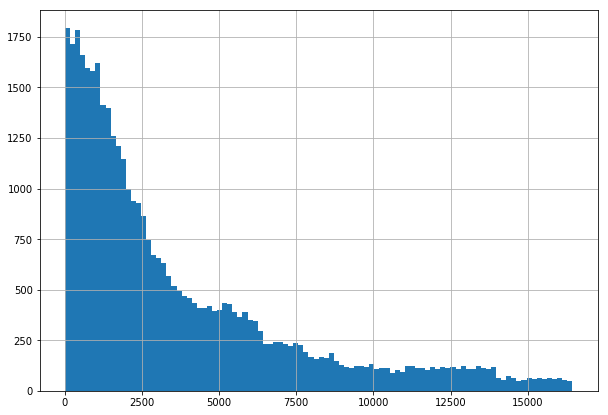

In [45]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

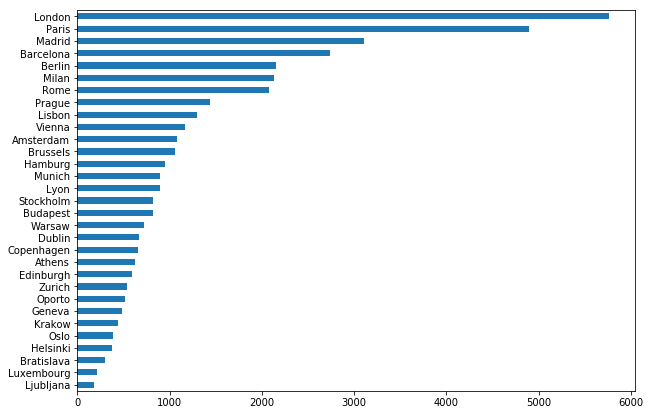

In [46]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

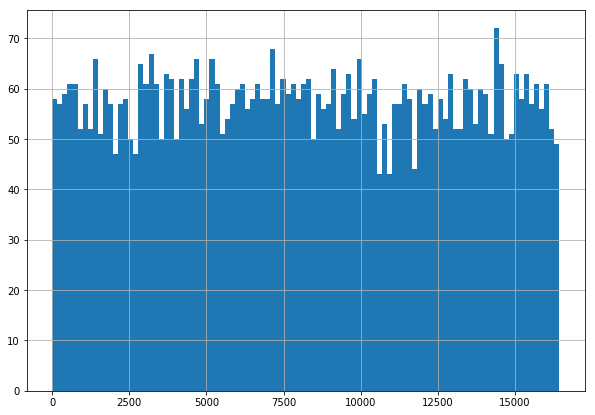

In [47]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

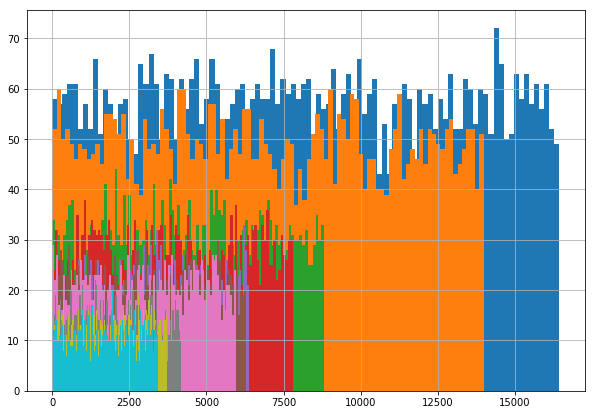

In [48]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Посмотрим распределение целевой переменной

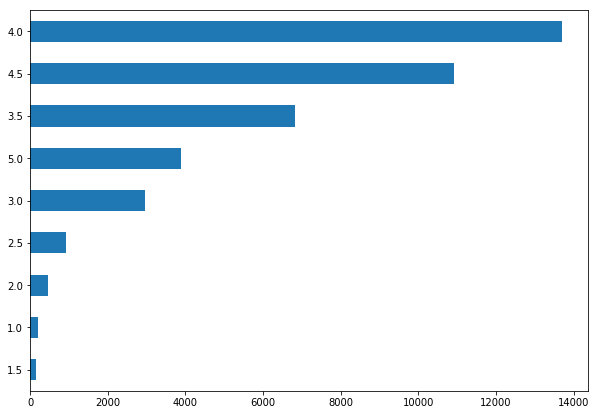

In [49]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

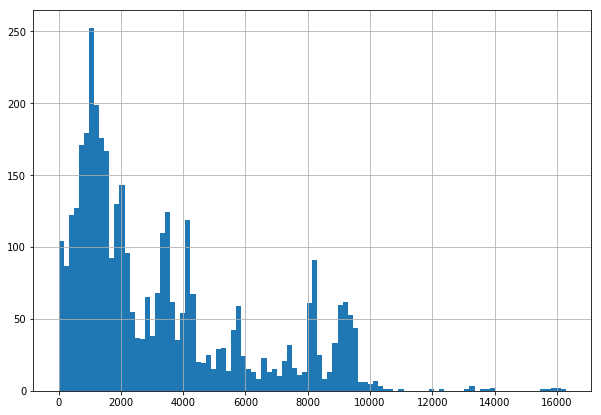

In [50]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

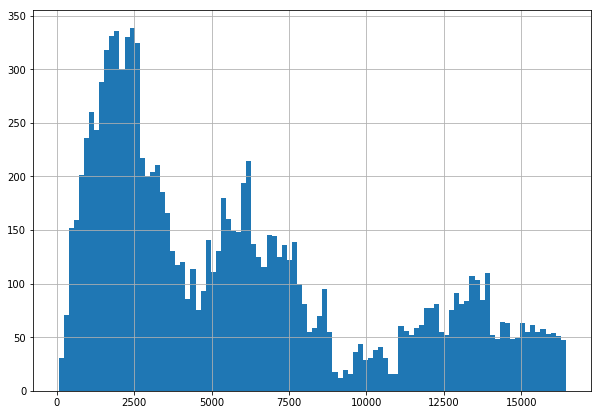

In [51]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### Корреляция признаков

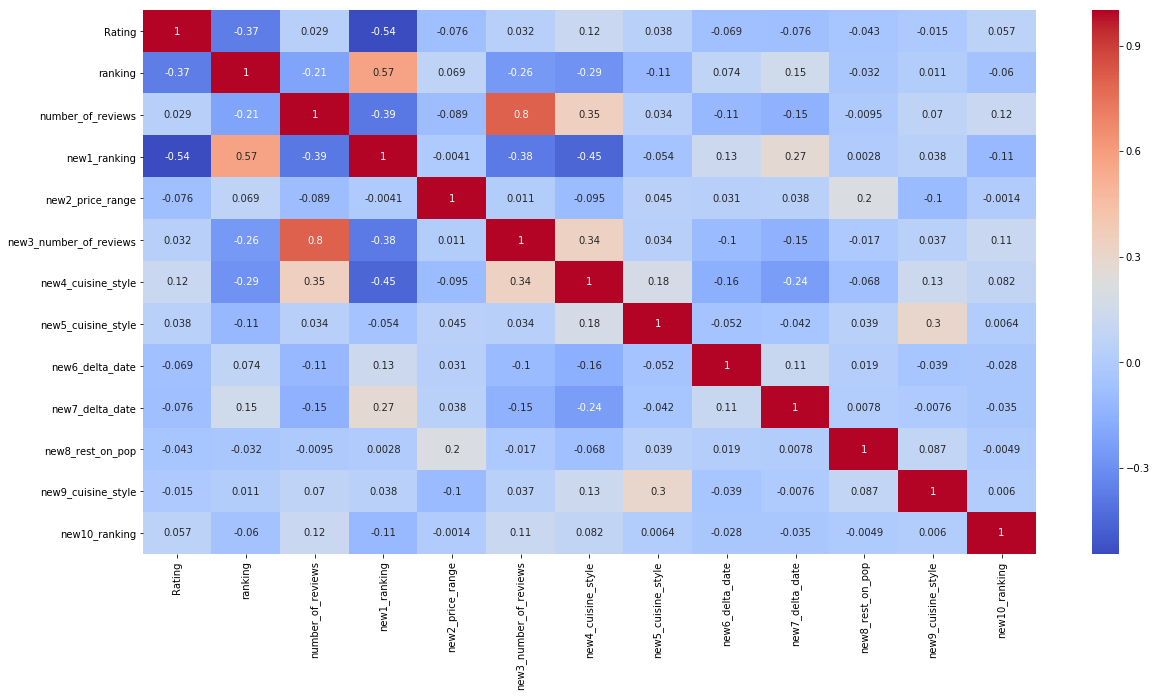

In [52]:
correlation = rest[rest['sample'] == 1][['Rating', 'ranking', 'price_range','number_of_reviews',
    'new1_ranking', 'new2_price_range', 'new3_number_of_reviews', 'new4_cuisine_style',
    'new5_cuisine_style', 'new6_delta_date', 'new7_delta_date', 'new8_rest_on_pop',
    'new9_cuisine_style', 'new10_ranking']].corr()
plt.figure(figsize=(20, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

Видим, что сильно коррелируют 'new1_ranking' и 'new3_number_of_reviews' со своими исходными 'ranking' и 'number_of_reviews'. 'new4_cuisine_style' на -0.45 коррелирует с 'new1_ranking'. С целевой 'Rating' на -0.54 коррелирует опять же 'new1_ranking'. Похоже, что 'new1_ranking' будет ключевым для работы модели ML.

Добавим полиномиальные признаки без первых трех. Видно, что у некоторых из них также есть существенная корреляция с целевой и теми признаками, на основе которых полиномиальные рассчитывались.

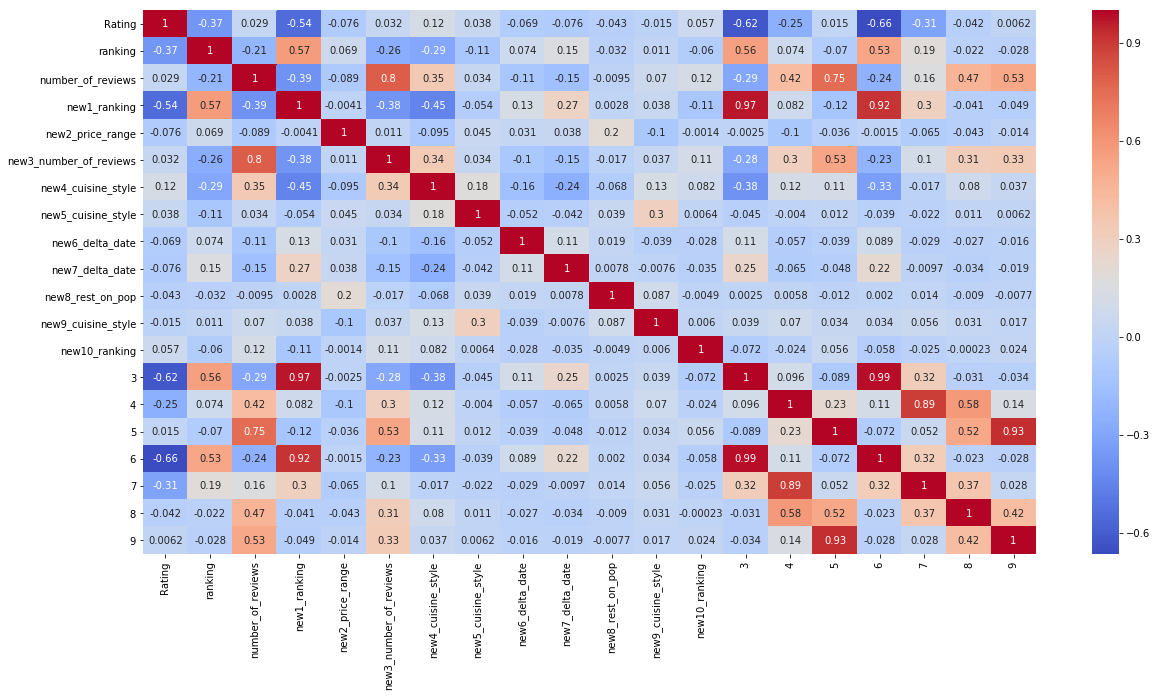

In [53]:
correlation = rest[rest['sample'] == 1][['Rating', 'ranking', 'price_range','number_of_reviews', 
    'new1_ranking', 'new2_price_range', 'new3_number_of_reviews', 'new4_cuisine_style',
    'new5_cuisine_style', 'new6_delta_date', 'new7_delta_date', 'new8_rest_on_pop', 'new9_cuisine_style', 
     'new10_ranking', 3,4,5,6,7,8,9]].corr()
plt.figure(figsize=(20, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

#### Запускаем и проверяем что получилось

In [54]:
#object_columns = [s for s in rest.columns if rest[s].dtypes == 'object']
#rest.drop(object_columns, axis = 1, inplace=True)

In [55]:
data = rest.drop(['city', 'cuisine_style', 'price_range', 'reviews'], axis = 1)

In [56]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [57]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [58]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 183), (40000, 183), (40000, 182), (32000, 182), (8000, 182))

# Model 
Сам ML

In [59]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [60]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [61]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   35.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [62]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.189600625


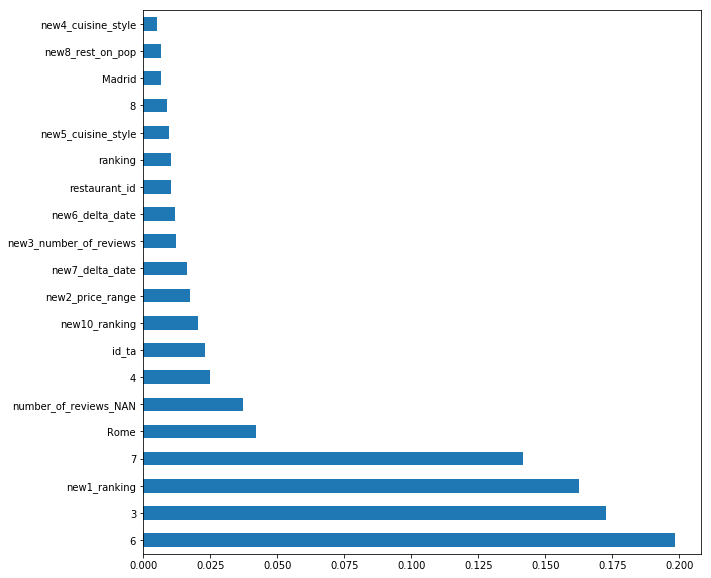

In [63]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

Итоги:
1.  создано 10 новых признаков
2.  самый полезный признак - 'ranking', нормированный по максимальному в городе ('new1_ranking')
3.  9 из 10 новых признаков попали в 20ку самых важных для модели
4.  остальные из 20ки самых важных - dummy и полиномиальные
5.  получен MAE 0.1896

# Submission
Если все устраевает - готовим Submission на кагл

In [64]:
test_data.sample(10)

,restaurant_id,ranking,number_of_reviews,id_ta,Rating,number_of_reviews_NAN,cuisine_style_NAN,price_range_NAN,reviews_NAN,new1_ranking,...,Warsaw,Zurich,new9_cuisine_style,3,4,5,6,7,8,9
4874,4874,645.0,284.0,0.9880,0.0,0,0,0,0,0.7322,...,0,0,1,0.536117,207.9448,80656.0,0.392545,152.257183,59056.3232,22906304.0
2088,2088,5022.0,46.0,1.5403,0.0,0,0,0,0,3.0540,...,0,0,1,9.326916,140.4840,2116.0,28.484401,429.038136,6462.2640,97336.0
4581,4581,10074.0,30.0,1.2089,0.0,0,0,0,0,7.2029,...,0,0,1,51.881768,216.0870,900.0,373.699190,1556.453052,6482.6100,27000.0
6014,6014,121.0,221.0,3.6192,0.0,0,0,0,0,0.5617,...,1,0,0,0.315507,124.1357,48841.0,0.177220,69.727023,27433.9897,10793861.0
257,257,1372.0,20.0,7.0796,0.0,0,0,0,0,2.1532,...,0,0,0,4.636270,43.0640,400.0,9.982817,92.725405,861.2800,8000.0
599,599,6636.0,46.0,1.0745,0.0,0,0,0,0,8.5121,...,0,0,1,72.455846,391.5566,2116.0,616.751410,3332.968935,18011.6036,97336.0
9011,9011,1567.0,38.0,8.8142,0.0,0,1,1,0,2.4972,...,0,0,1,6.236008,94.8936,1444.0,15.572559,236.968298,3605.9568,54872.0
186,186,1913.0,10.0,9.7421,0.0,0,1,1,0,5.1466,...,0,0,1,26.487492,51.4660,100.0,136.320524,264.874916,514.6600,1000.0
4933,4933,1966.0,25.0,9.8149,0.0,0,0,0,0,7.1155,...,0,0,0,50.630340,177.8875,625.0,360.260186,1265.758506,4447.1875,15625.0
3121,3121,805.0,38.0,11.8579,0.0,0,0,0,0,2.4739,...,0,0,0,6.120181,94.0082,1444.0,15.140716,232.566886,3572.3116,54872.0


In [65]:
test_data = test_data.drop(['Rating'], axis=1)

In [66]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [67]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [68]:
predict_submission

array([3.11 , 4.245, 4.41 , ..., 3.105, 4.31 , 4.345])

In [69]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.110
1,id_1,4.245
2,id_2,4.410
3,id_3,4.300
4,id_4,4.450
5,id_5,4.290
6,id_6,2.000
7,id_7,3.410
8,id_8,4.175
9,id_9,4.595


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
